# Paper figures of the IHIST simulations (transRES and CTL)

## 1. Settings

### 1.1 Import the necessary python libraries

In [1]:
from __future__ import print_function
import sys
import os
from getpass import getuser
import string
import subprocess
import numpy as np
import matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
import netCDF4 as netcdf4
import xarray as xr
import regionmask
import cartopy.crs as ccrs
from IPython.display import display, Math, Latex
import datetime
import warnings

from iv_utils import *


### 1.2 General Settings

In [2]:
# set directories
outdir = '/glade/scratch/ivanderk/'

# Define directory where processing is done -- subject to change
procdir = '/glade/work/ivanderk/postprocessing/' 

# go to processing directory 
os.chdir(procdir)

# define directory where inputdata is located
inputdir = '/glade/scratch/ivanderk/inputdata/clm_input/RES/'

# ignore all runtime warnings
warnings.filterwarnings('ignore')

### 1.3 User Settings

In [3]:
# set case name
case_res ='i.IHistClm50Sp.f09_g17.transRES'
case_ctl ='i.IHistClm50Sp.f09_g17.CTL'

# reference case, necessary for functions
case   = 'i.IHistClm50Sp.f09_g17.CTL'


# run settings -- change this to terms directly? 
block = 'lnd'  # lnd data
               # atm data
               # rof data
stream = 'h0'  # h0 output block
               # h1 output block
               # h2 output block
        
# define start and end year
spstartyear = '1890'   # spin up start year 
startyear   = '1900'   # start year, spin up excluded
endyear     = '2014'   # last year of the simulation

# constants


In [4]:
# plotting settings

mpl.rc('axes',edgecolor='grey')
mpl.rc('axes',labelcolor='dimgrey')
mpl.rc('xtick',color='dimgrey')
mpl.rc('xtick',labelsize=12)
mpl.rc('ytick',color='dimgrey')
mpl.rc('ytick',labelsize=12)
mpl.rc('axes',titlesize=14)
mpl.rc('axes',labelsize=12)
mpl.rc('legend',fontsize='large')
mpl.rc('text',color='dimgrey')

## 2. Functions

### 2.1 Functions to open datasets

In [5]:
# open nc variable as dataset  
def open_ds(var,case=case,stream=stream):
           
    tfreqs = {'h0' : 'month_1'                     , 'h1' : 'day_1'                            , 'h2' : 'month_1'}
    tspans = {'h0' : spstartyear+'01-'+endyear+'12', 'h1' : spstartyear+'0101-'+ endyear+'1231', 'h2' : spstartyear+'01-'+endyear+'12'} 

    model = {'lnd' : 'clm2', 'atm' : 'cam', 'rof' : 'mosart'}

    # Define directory where timeseries data is stored
    tseriesdir = outdir + 'archive/' + case + '/' + block + '/proc/tseries/' + tfreqs[stream] + '/'

    # define filename
    fn = case + '.'+ model[block] + '.' + stream + '.' + var + '.' + tspans[stream] +'.nc'

    # check if variable timeseries exists and open variable as data array
    if not os.path.isfile(tseriesdir + fn):
        print(fn + ' does not exists in ')
        print(tseriesdir)
    else: 
        ds = xr.open_dataset(tseriesdir+fn)
    return ds


# function to cut out analysis period out of data-array (1900-2015)
def extract_anaperiod(da, stream): 
    
    # number of spin up years
    nspinupyears = int(startyear) - int(spstartyear)
    
    if nspinupyears == 0 :
        # no spin up 
        da = da[:-1,:,:]
        
    elif stream == 'h1' : # this option still to test 
        # daily timesteps
        # last day of previous year is also saved in variable therefore add one
        nspinupdays = (nspinupyears * 365) + 1
    
        # exclude spin up year and last timestep ()
        da = da[nspinupdays:-1,:,:]
        
    else: 
        # spin up with monthly timestep
        # first month of first year is not saved in variable therefore substract one
        nspinupmonths = (nspinupyears * 12) - 1
    
        # exclude spin up year and last timestep ()
        da = da[nspinupmonths:-1,:,:]

    return da

# check if in hydrol variable list and if so, convert units
def conv_hydrol_var(var, da_in, hydrol_vars=False):
    
    # hydrological variables not defined when function is used - use predefined list
    if not hydrol_vars: 
        hydrol_vars = ['PRECT','PRECMC', 'PRECC','PRECL','Rx1day', 'QRUNOFF', 'QRUNOFF_TO_COUPLER']
        
    if var in hydrol_vars: 
        da_out = conv_m_s_to_mm_day(da_in)
        
    else: 
        da_out = da_in
        
    return da_out

# conversion function
def conv_m_s_to_mm_day(da_in):

    if not da_in.attrs['units'] == 'mm/day':
        da_out = da_in * 86400000  
        # update attributes and change units
        da_out.attrs= da_in.attrs
        da_out.attrs['units'] = 'mm/day' 
    else: 
        da_out = da_in
        
    return da_out


# open variable as data-array
def open_da(var, case=case, stream=stream):
    
    ds = open_ds(var, case, stream)
    da = ds[var]
    
    # extract analysis period - not necessary
    da = extract_anaperiod(da, stream)
    
    # convert hydrological variables (only if they are in the list)
    da = conv_hydrol_var(var, da)
    
    return da

def open_da_delta(var, case, case_ref, stream='h0'): 

    # Load the two datasets
    da_res = open_da(var,case=case, stream=stream)
    da_ctl = open_da(var,case=case_ref, stream=stream)

    # calculate difference and update attributes
    da_delta = da_res - da_ctl

    da_delta.attrs['long_name'] = '$\Delta$ '+ da_ctl.long_name
    da_delta.attrs['units'] = da_ctl.units
    da_delta.name = '$\Delta$ '+ da_ctl.name

    return da_delta


def open_da_delta_h1(var, case, case_ref): 

    # Load the two datasets
    da_res = open_da(var,case=case, stream='h1')
    da_ctl = open_da(var,case=case_ref, stream='h1')

    # calculate difference and update attributes
    da_delta = da_res - da_ctl

    da_delta.attrs['long_name'] = '$\Delta$ '+ da_ctl.long_name
    da_delta.attrs['units'] = da_ctl.units
    da_delta.name = '$\Delta$ '+ da_ctl.name

    return da_delta

### 2.2 Functions to perform calculations

In [6]:
# open reservoir mask (threshold in %)
def get_resmask(threshold = 0):
    da = open_da('PCT_LANDUNIT', case=case_res)
    pctlake = da.sel(ltype = 4) 
    dpctlake = pctlake[-1,:,:] - pctlake[0,:,:] 
    resmask = dpctlake > threshold

    return resmask

### 2.3 Functions to plot

In [7]:
def plot_annual_respct(da_delta, ax=False, title=False, legend=True, vlims = False, panel_label = False):
    """plot the seasonal cycle averaged over reservoir grid cells for different thresholds"""
    import matplotlib as mpl

    # choosing sequential colors for lines

    cmap = mpl.cm.get_cmap('YlGnBu')
    color_0 = cmap(0.2)
    color_1 = cmap(0.3)
    color_2 = cmap(0.45)
    color_5 = cmap(0.6)
    color_10 = cmap(0.75)
    color_15 = cmap(0.9)

    if ax == False: 
        f, ax = plt.subplots(figsize=(7,5))
    da_delta.where(get_resmask(threshold=0)).groupby('time.year').mean().mean(dim=('lat','lon')).plot(ax=ax, color=color_0)
    da_delta.where(get_resmask(threshold=1)).groupby('time.year').mean().mean(dim=('lat','lon')).plot(ax=ax, color=color_1)
    da_delta.where(get_resmask(threshold=2)).groupby('time.year').mean().mean(dim=('lat','lon')).plot(ax=ax, color=color_2)
    da_delta.where(get_resmask(threshold=5)).groupby('time.year').mean().mean(dim=('lat','lon')).plot(ax=ax, color=color_5)
    da_delta.where(get_resmask(threshold=10)).groupby('time.year').mean().mean(dim=('lat','lon')).plot(ax=ax, color=color_10)
    da_delta.where(get_resmask(threshold=15)).groupby('time.year').mean().mean(dim=('lat','lon')).plot(ax=ax, color=color_15)

    legend_text = ['> 0%',   '> 1%', \
                   '> 2%',   '> 5% ', \
                   '> 10%', '> 15% ']
    ax.axhline(color='gray', linewidth = 0.8)
    ax.set_ylabel(da_delta.units)
    ax.set_xlabel(' ')
    ax.set_xlim(da_delta.groupby('time.year').mean().year[0],da_delta.groupby('time.year').mean().year[-1])
    ax.set_xticks([1900,1920,1940,1960,1980,2000,2014]);

    
    if not vlims == False: 
        ax.set_ylim(vlims)
    
    if legend == True:
        
        ax.legend(legend_text, frameon=False);
    
    if title == False: 
        ax.set_title(da_delta.long_name, loc='right');
    else: 
        ax.set_title(title, loc='right');        
        
    if panel_label != False:
        ax.text(0, 1.02, panel_label, color='dimgrey', fontsize=12, transform=ax.transAxes, weight = 'bold')
    return ax


In [8]:
def plot_annual_respct(da_delta, ax=False, title=False, legend=True, vlims = False, panel_label = False):
    """plot the seasonal cycle averaged over reservoir grid cells for different thresholds"""
    import matplotlib as mpl

    # choosing sequential colors for lines

    cmap = mpl.cm.get_cmap('YlGnBu')
    color_0 = cmap(0.2)
    color_1 = cmap(0.3)
    color_2 = cmap(0.45)
    color_5 = cmap(0.6)
    color_10 = cmap(0.75)
    color_15 = cmap(0.9)

    if ax == False: 
        f, ax = plt.subplots(figsize=(7,5))
    da_delta.where(get_resmask(threshold=0)).groupby('time.year').mean().mean(dim=('lat','lon')).plot(ax=ax, color=color_0)
    da_delta.where(get_resmask(threshold=1)).groupby('time.year').mean().mean(dim=('lat','lon')).plot(ax=ax, color=color_1)
    da_delta.where(get_resmask(threshold=2)).groupby('time.year').mean().mean(dim=('lat','lon')).plot(ax=ax, color=color_2)
    da_delta.where(get_resmask(threshold=5)).groupby('time.year').mean().mean(dim=('lat','lon')).plot(ax=ax, color=color_5)
    da_delta.where(get_resmask(threshold=10)).groupby('time.year').mean().mean(dim=('lat','lon')).plot(ax=ax, color=color_10)
    da_delta.where(get_resmask(threshold=15)).groupby('time.year').mean().mean(dim=('lat','lon')).plot(ax=ax, color=color_15)

    legend_text = ['> 0%',   '> 1%', \
                   '> 2%',   '> 5% ', \
                   '> 10%', '> 15% ']
    ax.axhline(color='gray', linewidth = 0.8)
    ax.set_ylabel(da_delta.units)
    ax.set_xlabel(' ')
    ax.set_xlim(da_delta.groupby('time.year').mean().year[0],da_delta.groupby('time.year').mean().year[-1])
    ax.set_xticks([1900,1920,1940,1960,1980,2000,2014]);

    
    if not vlims == False: 
        ax.set_ylim(vlims)
    
    if legend == True:
        
        ax.legend(legend_text, frameon=False);
    
    if title == False: 
        ax.set_title(da_delta.long_name, loc='right');
    else: 
        ax.set_title(title, loc='right');        
        
    if panel_label != False:
        ax.text(0, 1.02, panel_label, color='dimgrey', fontsize=12, transform=ax.transAxes, weight = 'bold')
    return ax


##  Paper figures

### 1. Lake area increase

In [9]:
# plot increase in res area
da_delta = open_da_delta('PCT_LANDUNIT',case_res,case_ctl)
dpctlake = da_delta.sel(ltype = 4)/100
area = open_ds('TSA').area

resarea = dpctlake*area

print('total reservoir area (km²)')
print(np.round(resarea[-1].sum().values))


total reservoir area (km²)
241748.0


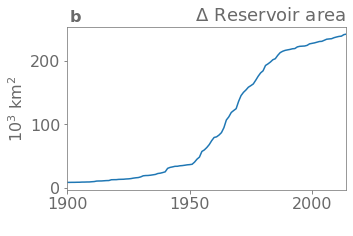

In [10]:
mpl.rc('ytick',labelsize=16)


fig , ax = plt.subplots(1,figsize=(5,3))
da_sum = resarea.sum(dim=('lon','lat')).groupby('time.year').mean('time')/10**3
xlims = (da_sum.year[0].values,da_sum.year[-1].values)
da_tseries = da_sum.plot(xlim=xlims)
plt.title(' $\Delta$ Reservoir area', loc='right', size=18)
plt.ylabel('10$^3$ km$^2$', fontsize=16);
plt.xlabel(' ');
plt.xticks([1900,1950,2000], fontsize=16);
plt.text(0.01, 1.03, 'b', color='dimgrey', fontsize=16, transform=ax.transAxes, weight = 'bold');

fig.savefig('./plots/landarea_timeseries.png',  bbox_inches='tight')

### 2. Land only timeseries

In [9]:
# open the delta of variables

dSHF = open_da_delta('FSH', case_res, case_ctl)
dSHF.attrs['units'] = 'W m$^{-2}$'
dSHF.attrs['long_name'] = '$\Delta$ SHF'

dLHF = open_da_delta('EFLX_LH_TOT', case_res, case_ctl)
dLHF.attrs['units'] = 'W m$^{-2}$'
dLHF.attrs['long_name'] = '$\Delta$ LHF'

dTWS = open_da_delta('TWS', case_res, case_ctl)
dTWS.attrs['long_name'] = '$\Delta$ TWS'

# albedo
SWin  = open_da('FSDS',  case_res) # same for both cases
SWout_ctl = open_da('FSR' ,  case_ctl)
SWout_res = open_da('FSR' ,  case_res)

albedo_ctl = SWout_ctl/SWin
albedo_res = SWout_res/SWin

dalbedo = albedo_res - albedo_ctl
dalbedo.name='$\Delta$ albedo'
dalbedo.attrs['units'] = '[-]'
dalbedo.attrs['long_name'] = '$\Delta$ Albedo'

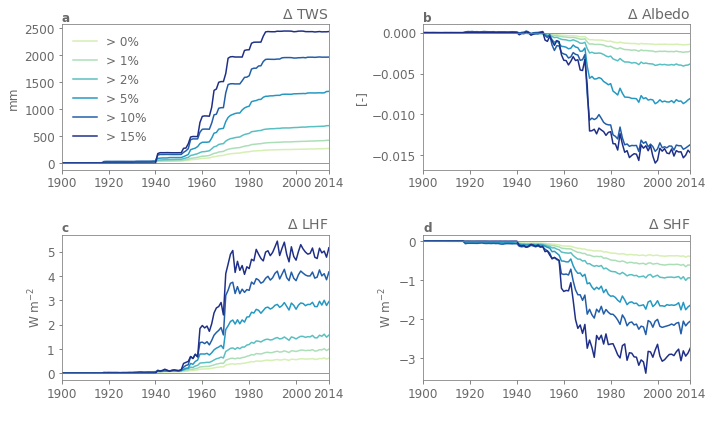

In [11]:
fig, axes = plt.subplots(2,2,figsize=(10,6))
axes = axes.flatten()

plot_annual_respct(dTWS, ax=axes[0],  vlims = False, panel_label='a')
plot_annual_respct(dalbedo,    ax=axes[1], legend= False, vlims = False, panel_label='b')

plot_annual_respct(dLHF,    ax=axes[2],  legend= False, vlims = False, panel_label='c' )
plot_annual_respct(dSHF,    ax=axes[3],  legend= False, vlims = False, panel_label='d')
fig.tight_layout()

fig.savefig('./plots/landonly_timeseries.png',  bbox_inches='tight')

In [13]:
# print values for paper
print('SHF in 2014')
print('>0%')
print(dSHF.where(get_resmask(threshold=0)).groupby('time.year').mean().mean(dim=('lat','lon'))[-1].values)
print('>15%')
print(dSHF.where(get_resmask(threshold=15)).groupby('time.year').mean().mean(dim=('lat','lon'))[-1].values)
print()

print('LHF in 2014')
print('>0%')
print(dLHF.where(get_resmask(threshold=0)).groupby('time.year').mean().mean(dim=('lat','lon'))[-1].values)
print('>15%')
print(dLHF.where(get_resmask(threshold=15)).groupby('time.year').mean().mean(dim=('lat','lon'))[-1].values)
print()

print('TWS in 2014')
print('>0%')
print(dTWS.where(get_resmask(threshold=0)).groupby('time.year').mean().mean(dim=('lat','lon'))[-1].values)
print('>15%')
print(dTWS.where(get_resmask(threshold=15)).groupby('time.year').mean().mean(dim=('lat','lon'))[-1].values)
print()

print('albedo in 2014')
print('>0%')
print(dalbedo.where(get_resmask(threshold=0)).groupby('time.year').mean().mean(dim=('lat','lon'))[-1].values)
print('>15%')
print(dalbedo.where(get_resmask(threshold=15)).groupby('time.year').mean().mean(dim=('lat','lon'))[-1].values)
print()




SHF in 2014
>0%
-0.3914796
>15%
-2.735437

LHF in 2014
>0%
0.61818
>15%
5.160262

TWS in 2014
>0%
270.8567
>15%
2429.3872

albedo in 2014
>0%
-0.0013965286
>15%
-0.014717964



In [17]:
LAKEICEFRAC = open_da('LAKEICEFRAC_SURF', case_res)* dpctlake
LAKEICEFRAC.attrs['units'] = 'Lake ice fraction'
LAKEICEFRAC.attrs['long_name'] = '$\Delta$ lakeice fraction'


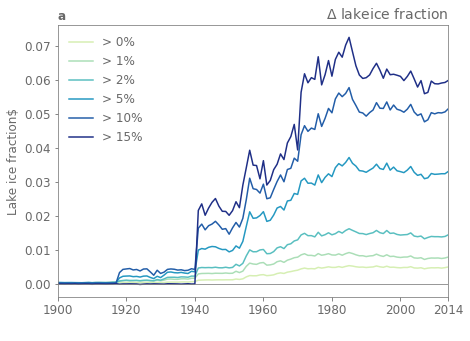

In [18]:
plot_annual_respct(LAKEICEFRAC, vlims = False, panel_label='a')


In [36]:
dLHF_yearmean = open_da_delta('EFLX_LH_TOT', case_res, case_ctl).groupby('time.year').mean()
area = open_ds('TSA').area * 10e6 # m²

lh_vap = 2.501e6 # J/kg  latent heat of vaporization
seconds_per_year = 31556925.216 
conversion_factor = 0.001*seconds_per_year/(lh_vap) # converts W/m² to m/year
conversion_factor

dET_m = dLHF_yearmean * conversion_factor # m/year
dET_m.attrs['units'] = 'm year$^{-1}$'

dET = dET_m * area
dET.attrs['units'] = 'm$^{3}$ year$^{-1}$'
dET.attrs['long_name'] = '$\Delta$ ET (volume)'


In [38]:
dET[-1].sum()*10e-9

<xarray.DataArray ()>
array(9871.41963776)
Coordinates:
    year     int64 2014

In [10]:
dET_m = dLHF_yearmean * conversion_factor # m/year
dET_m.attrs['units'] = 'm year$^{-1}$'

dET = dET_m * area
dET.attrs['units'] = 'm$^{3}$ year$^{-1}$'
dET.attrs['long_name'] = '$\Delta$ ET (volume)'



In [69]:
# calculate total TWS

area = open_ds('TSA').area# m²
dTWS_cubicm = (dTWS.where(get_resmask())*area.where(get_resmask())*10e-6) # km³
dTWS_tot = dTWS_cubicm[-1].sum(dim=('lat','lon')) # km³

print('Total water storage added through reservoirs')
print(np.round(dTWS_tot.values))
print('km³')# km³

Total water storage added through reservoirs
30013.0
km³


In [70]:
# Calculate water added in reservoir bodies themselves
# find lake depth
lakedepth = xr.open_dataset(inputdir+'surfdata_0.9x1.25_hist_16pfts_Irrig_CMIP6_simyr2015_RES_c200305.nc').LAKEDEPTH.rename({'lsmlat': 'lat','lsmlon': 'lon'})
res_volume = resarea[-1] * lakedepth*10e-3 # in km³
totres_volume = res_volume.sum().values
print('Water added in reservoirs alone')
print(np.round(totres_volume))
print('km³')

Water added in reservoirs alone
26148.0
km³


In [74]:
# fractin
print(np.round(totres_volume/dTWS_tot.values*100))

87.0


### 2. Land only timeseries - only neigbouring gridcells

In [29]:
def plot_annual_pct_neighb(da_delta, ax=False, title=False, legend=True, vlims = False, panel_label = False, nores = False):
    """plot the seasonal cycle averaged over reservoir grid cells for different thresholds"""
    import matplotlib as mpl

    # choosing sequential colors for lines
    resmask = get_resmask()
    cmap = mpl.cm.get_cmap('YlGnBu')
    color_0 = cmap(0.2)
    color_1 = cmap(0.3)
    color_2 = cmap(0.45)
    color_5 = cmap(0.6)
    color_10 = cmap(0.75)
    color_15 = cmap(0.9)

    if ax == False: 
        f, ax = plt.subplots(figsize=(7,5))
    
    ax.axhline(color='gray', linewidth = 0.8, label='_nolegend_')

        
    if nores==False: 
        da_delta.where(get_resmask(threshold=0)).groupby('time.year').mean().mean(dim=('lat','lon')).plot(ax=ax, color=color_10)
        legend_text = ['Reservoir cells',  '8 neigbouring cells', \
                   '32 neigbouring cells',   'Land without reservoir cells']
    else: 
        legend_text = [ '8 neigbouring cells', \
                   '32 neigbouring cells',   'all land cells without res']
        

    da_delta.where(get_resmask_1step_nores()).groupby('time.year').mean().mean(dim=('lat','lon')).plot(ax=ax, color=color_5)
    da_delta.where(get_resmask_2step_nores()).groupby('time.year').mean().mean(dim=('lat','lon')).plot(ax=ax, color=color_2)
    da_delta.where(np.logical_not(resmask)).groupby('time.year').mean().mean(dim=('lat','lon')).plot(ax=ax, color=color_0)


    ax.set_ylabel(da_delta.units)
    ax.set_xlabel(' ')
    ax.set_xlim(da_delta.groupby('time.year').mean().year[0],da_delta.groupby('time.year').mean().year[-1])
    ax.set_xticks([1900,1920,1940,1960,1980,2000,2014]);

    
    if not vlims == False: 
        ax.set_ylim(vlims)
    
    if legend == True:
        
        ax.legend(legend_text, frameon=False, loc='lower left', fontsize=11);
    
    if title == False: 
        ax.set_title(da_delta.long_name, loc='right');
    else: 
        ax.set_title(title, loc='right');        
        
    if panel_label != False:
        ax.text(0, 1.02, panel_label, color='dimgrey', fontsize=12, transform=ax.transAxes, weight = 'bold')
    return ax


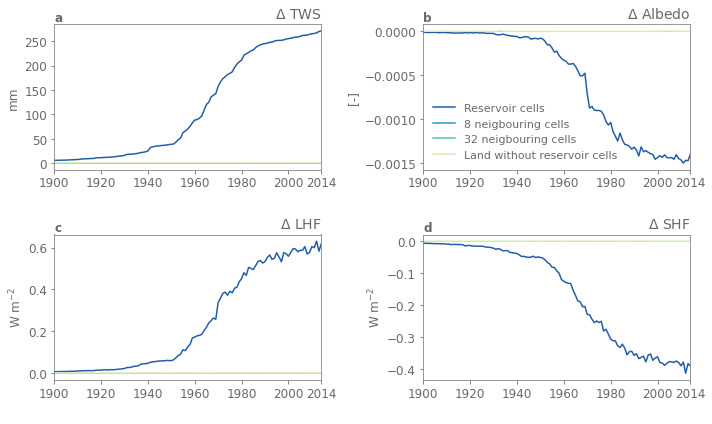

In [30]:
fig, axes = plt.subplots(2,2,figsize=(10,6))
axes = axes.flatten()

plot_annual_pct_neighb(dTWS, ax=axes[0],  vlims = False, legend = False, panel_label='a')
plot_annual_pct_neighb(dalbedo,    ax=axes[1], legend= True, vlims = False, panel_label='b')

plot_annual_pct_neighb(dLHF,    ax=axes[2],  legend= False, vlims = False, panel_label='c' )
plot_annual_pct_neighb(dSHF,    ax=axes[3],  legend= False, vlims = False, panel_label='d')
fig.tight_layout()

fig.savefig('./plots/landonly_timeseries_neighb.png',  bbox_inches='tight')